<div align="center" style="font-size:24px;"><b>End-to-End &beta;-Variational Autoencoder (VAE) for SVHN-Normal Dataset</b></div>

This notebook presents a comprehensive analysis and implementation of a $\beta$-Variational Autoencoder (VAE) using the SVHN-Normal dataset in the Keras framework. Building upon our previous work with the MNIST dataset, this version extends our exploration to a more complex and diverse dataset that includes The Street View House Numbers dataset (SVHN) contains 32x32 cropped images of house numbers obtained from Google Street View. Testing my pre-trained MNIST model on the SVHN (Street View House Numbers) dataset is an interesting challenge due to the differences in image format (32 $\times$ 32 vs. 28 $\times$ 28) and content (Color vs. Grayscale). 

## Table of Contents
1. [Library Imports](#Library-Imports)
2. [Loading the SVHN-Normal Dataset](#Loading-the-SVHN-Normal-Dataset)
3. [Preprocessing SVHN-Normal Data](#Preprocessing-SVHN-Normal-Data)
4. [Loading Pre-Trained Model](#Loading-Pre-Trained-Model)
6. [Evaluation Pre-Trained Model](#Evaluation-Pre-Trained-Model)


<a id="Library Imports"></a>
## Library Imports

In [ ]:
#!pip install seaborn
#!pip install tensorflow
#!pip install scikit-image
#!pip install extra-keras-datasets    # refer to: https://github.com/machinecurve/extra_keras_datasets.git
#!pip install opencv-python

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Data Handling and Numerical Libraries
import numpy as np                   
import matplotlib.pyplot as plt             

# Keras - Deep Learning API
import keras                                # High-level neural networks API
from keras import backend as K  

from extra_keras_datasets import svhn     # The Street View House Numbers dataset (SVHN)
import cv2

import random
import sys


from keras.models import load_model  
from keras.losses import mse

from keras.callbacks import (               # Training callbacks
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

import tensorflow as tf


/Users/mahdihabibi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


<a id="Loading the SVHN-Normal Dataset"></a>
## Loading the SVHN-Normal Dataset

In [3]:
# Loading the SVHN-Normal dataset
(x_train, y_train), (x_test, y_test) = svhn.load_data(type='normal')

INFO:root:Loading dataset = svhn


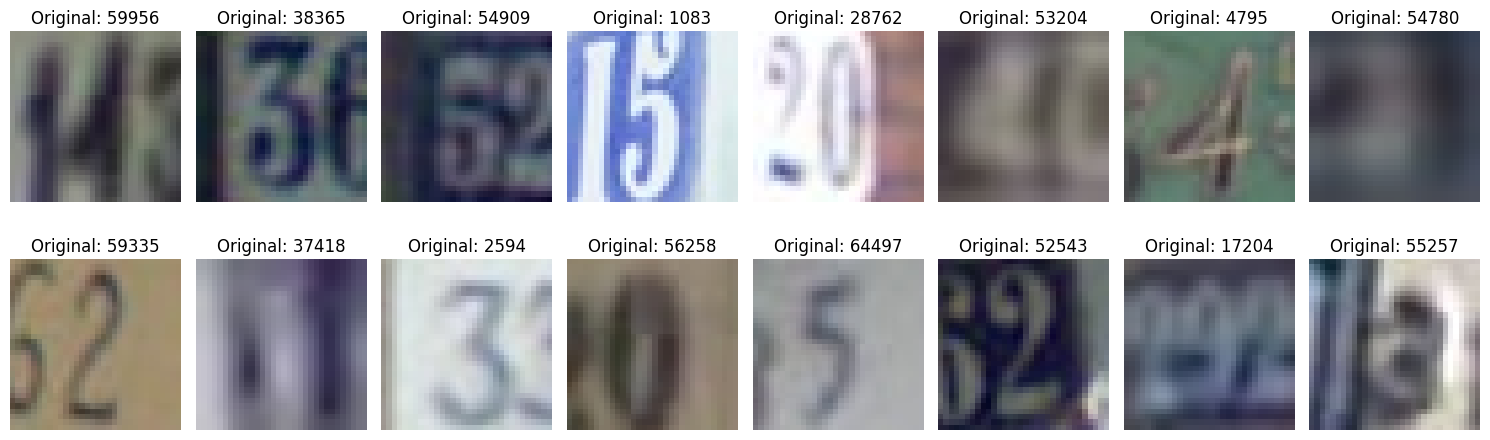

In [4]:
# Visualizing some sample images from the original SVHN dataset (before processing)

def visualize_samples(original_data, sample_indices, figsize=(15, 5)):
    """
    Visualizes a set of original images from the provided dataset.

    :param original_data: The dataset containing the original color images.
    :param sample_indices: A list of indices for the images to be visualized.
    :param figsize: Size of the figure for the plots.
    """
    plt.figure(figsize=figsize)

    for i, img_index in enumerate(sample_indices):
        # Display original color image
        plt.subplot(2, 8, i + 1)
        plt.imshow(original_data[img_index])
        plt.title(f'Original: {img_index}')
        plt.axis('off')


    plt.tight_layout()
    plt.show()

# Number of samples to visualize
num_samples = 16

# Randomly select indices for the samples
random_indices = np.random.choice(len(x_train), num_samples, replace=False)

# Visualize the sampled images
visualize_samples(x_train, random_indices)

Before diving into the preprocessing steps, it's crucial to understand the format and type of data we're dealing with. Let's examine the data type and shape of the `x_train` dataset:

In [5]:
print(f"Data Type: {x_train.dtype}")
print(f"Shape: {x_train.shape}")

Data Type: uint8
Shape: (73257, 32, 32, 3)


<a id="Preprocessing SVHN-Normal Data"></a>
## Preprocessing SVHN-Normal Data

**Note:** 

In general, the image processing for this dataset includes three important steps:

1- **Converting to Grayscale:** As my model has been pretrained on MNIST as a grayscale dataset, we should convert color images in SVHN dataset to grayscale.

2- **Resizing:** Resize the images to 28x28 to match the MNIST format.

3- **Normalization:** Normalizing the images to the range [0, 1] is appropriate and should be done since it matches the preprocessing applied to the MNIST dataset.

In [6]:
# Function to preprocess the images
def preprocess_images(images):
    processed_images = []
    for img in images:
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Resize to 28x28
        resized = cv2.resize(gray, (28, 28))
        processed_images.append(resized)
    return np.array(processed_images)

# Preprocess training and testing images
x_train_processed = preprocess_images(x_train)
x_test_processed = preprocess_images(x_test)

# Normalize the images
x_train_processed = x_train_processed.astype('float32') / 255.
x_test_processed = x_test_processed.astype('float32') / 255.

In [7]:
# Check again the type and shape of elements in x_train_processed after formatting.
print(f"Data Type: {x_train_processed.dtype}")
print(f"Shape: {x_train_processed.shape}")

Data Type: float32
Shape: (73257, 28, 28)


In [8]:
# Retrieving the number of images and their dimensions from the train set
img_num_train = x_train_processed.shape[0]
img_width     = x_train_processed.shape[1]
img_height    = x_train_processed.shape[2]

# Displaying the train set information
print(f"The SVHN-Normal train set contains {img_num_train} images, each with dimensions:"
      f"\n(width x height) = ({img_width} x {img_height}) pixels.")

# Retrieving the number of images from the test set
img_num_test  = x_test_processed.shape[0]

# Displaying the test set information
print(f"The SVHN-Normal test set also contains {img_num_test} images with the same dimensions as the train set.")

The SVHN-Normal train set contains 73257 images, each with dimensions:
(width x height) = (28 x 28) pixels.
The SVHN-Normal test set also contains 26032 images with the same dimensions as the train set.


**Reshaping Image Data for Convolutional Neural Network Input**

**Note**: In machine learning libraries like Keras, images need to be formatted in a specific shape (height, width, channels). The term "channels" refers to the number of color channels in the image. For grayscale images like those in the processed SVHN dataset, there is only one channel. Therefore, we need to reshape our image data to fit this format.

In [9]:
# Define the number of channels: 1 for grayscale images
num_channels = 1

# Reshape the training and test datasets to include the channel dimension
x_train_processed = x_train_processed.reshape(img_num_train, img_height, img_width, num_channels)
x_test_processed = x_test_processed.reshape(img_num_test, img_height, img_width, num_channels)

# Define the input dimensions for the CNN
input_dimensions = (img_height, img_width, num_channels)

# Display the reshaped dimensions
print(f"Dimensions of each image for the model: (img_height, img_width, num_channels) = {input_dimensions}.")
print(f"Reshaped training data shape: {x_train_processed.shape}")

Dimensions of each image for the model: (img_height, img_width, num_channels) = (28, 28, 1).
Reshaped training data shape: (73257, 28, 28, 1)


In [10]:
from sklearn.model_selection import train_test_split

# Split the training data into fine-tuning and validation sets
x_train_fine, x_val, _, _ = train_test_split(
    x_train_processed, 
    np.zeros((x_train_processed.shape[0], )),  # Dummy variable for splitting
    test_size=0.1,  # 10% for validation
    random_state=42  # Seed for reproducibility
)

print(f"Fine-tuning data shape: {x_train_fine.shape}")
print(f"Validation data shape: {x_val.shape}")


Fine-tuning data shape: (65931, 28, 28, 1)
Validation data shape: (7326, 28, 28, 1)


**Visualizing the processed data to see a few arbitrary images**

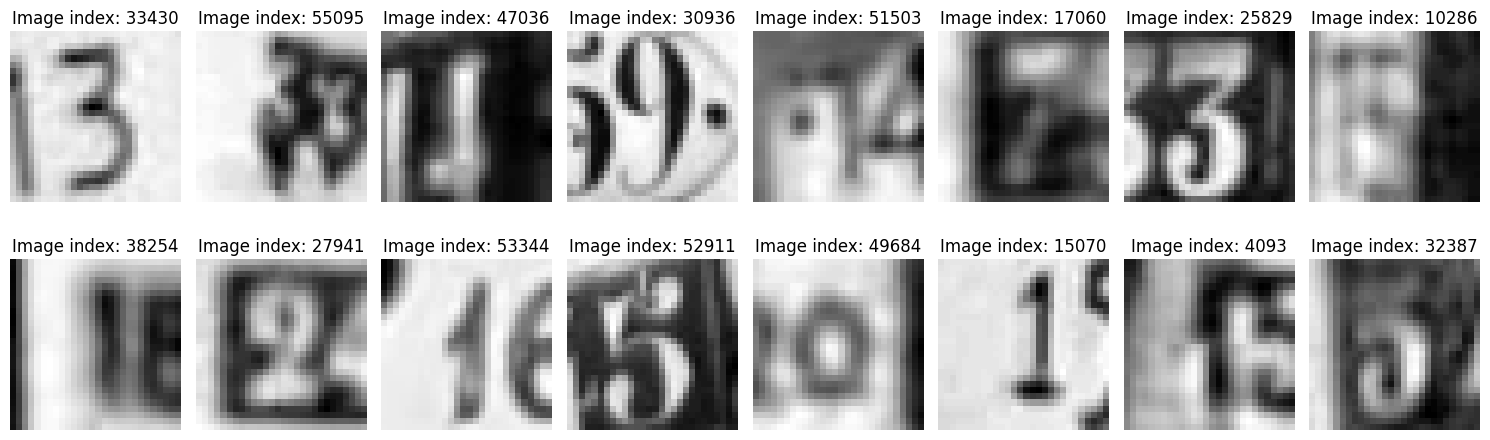

In [11]:
def visualize_samples(data, sample_indices, figsize=(15, 5)):
    """
    Visualizes a set of images from the provided dataset.

    :param data: The dataset containing the images.
    :param sample_indices: A list of indices for the images to be visualized.
    :param figsize: Size of the figure for the plots.
    """
    plt.figure(figsize=figsize)

    for i, img_index in enumerate(sample_indices):
        plt.subplot(2, 8, i + 1)
        plt.imshow(data[img_index][:, :, 0], cmap='gray')
        plt.title(f'Image index: {img_index}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Number of samples to visualize
num_samples = 16

# Randomly select indices for the samples
random_indices = np.random.choice(len(x_train_fine), num_samples, replace=False)

# Visualize the sampled images
visualize_samples(x_train_fine, random_indices)

**Note:** Be aware that resizing can distort some images, potentially making digits harder for the model to recognize, as seen from some of images above.

<a id="Model Architecture"></a>
## Model Architecture

In this part of my project, I am taking a novel approach by leveraging a pre-trained Variational Autoencoder (VAE) model originally trained on the MNIST dataset. My objective is to adapt this model for the SVHN-Normal dataset. The VAE model comprises three primary components:

1. **Encoder:** Originally trained on MNIST, the encoder compresses input data into a latent space, capturing essential features. For SVHN-Normal, I will explore how this encoder, pre-trained on digits, performs with a more diverse set of characters.

2. **Latent Space:** The core of the VAE, where the data is represented in a compressed form. This space is crucial for the generative aspect of the VAE, and I will investigate its effectiveness in representing a broader range of characters.

3. **Decoder:** This component reconstructs the input data from its latent representation. The decoder, trained on MNIST, will now be tasked with reconstructing SVHN-Normal characters, which will be a test of its generalizability.

By utilizing a pre-trained model, I aim to investigate the transferability of learned features from one dataset to another and the model's ability to adapt to new, more complex data. This approach not only saves computational resources but also provides insights into the flexibility and robustness of our VAE model.

<a id="Loading Pre-Trained Model"></a>
## Loading Pre-Trained Model

In [12]:
# Path to the saved model
pretrained_model_path = '/Volumes/D/GitHub-Portfolio/CompressNetMNIST/models/best_model_Autoencoder.keras'

# Load the pre-trained model
pretrained_vae = load_model(pretrained_model_path)

# Display the model's architecture
pretrained_vae.summary()

Model: "full_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input_layer (Input  [(None, 28, 28, 1)]       0         
 Layer)                                                          
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                  

In [13]:
model_checkpoint = ModelCheckpoint(
    filepath='/Volumes/D/GitHub-Portfolio/CompressNetMNIST/models/best_fine_tuned_model_Autoencoder.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'    # The target, 'val_loss', should be minimized
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min'    
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,   # Multiplicative factor of learning rate reduction
    patience=5,
    min_lr=0.00001, # Lower bound on the learning rate
    verbose=1
)

callbacks_list = [model_checkpoint, early_stopping, reduce_lr]

In [14]:
# Compile the model with a smaller learning rate for fine-tuning
fine_tuning_lr = 0.00005  # You can adjust this value as needed
#pretrained_vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tuning_lr), loss='mse')
pretrained_vae.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00005), loss='mse')

# Fine-tune the model
history = pretrained_vae.fit(
    x_train_fine, x_train_fine,
    epochs=50,  # Adjust as needed
    batch_size=32,  # Adjust as needed
    validation_data=(x_val, x_val),
    callbacks=callbacks_list
)


Epoch 1/50
2061/2061 [==============================] - ETA: 0s - loss: 0.0057
Epoch 1: val_loss improved from inf to 0.00353, saving model to /Volumes/D/GitHub-Portfolio/CompressNetMNIST/models/best_fine_tuned_model_Autoencoder.keras
2061/2061 [==============================] - 88s 43ms/step - loss: 0.0057 - val_loss: 0.0035 - lr: 5.0000e-05
Epoch 2/50
2060/2061 [============================>.] - ETA: 0s - loss: 0.0033
Epoch 2: val_loss improved from 0.00353 to 0.00308, saving model to /Volumes/D/GitHub-Portfolio/CompressNetMNIST/models/best_fine_tuned_model_Autoencoder.keras
2061/2061 [==============================] - 90s 44ms/step - loss: 0.0033 - val_loss: 0.0031 - lr: 5.0000e-05
Epoch 3/50
2060/2061 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 3: val_loss improved from 0.00308 to 0.00285, saving model to /Volumes/D/GitHub-Portfolio/CompressNetMNIST/models/best_fine_tuned_model_Autoencoder.keras
2061/2061 [==============================] - 90s 44ms/step - loss: 

<a id="Evaluation Pre-Trained Model"></a>
## Evaluation Pre-Trained Model


### Visualization of original and reconstructed images

1/1 [==============================] - 0s 10ms/step


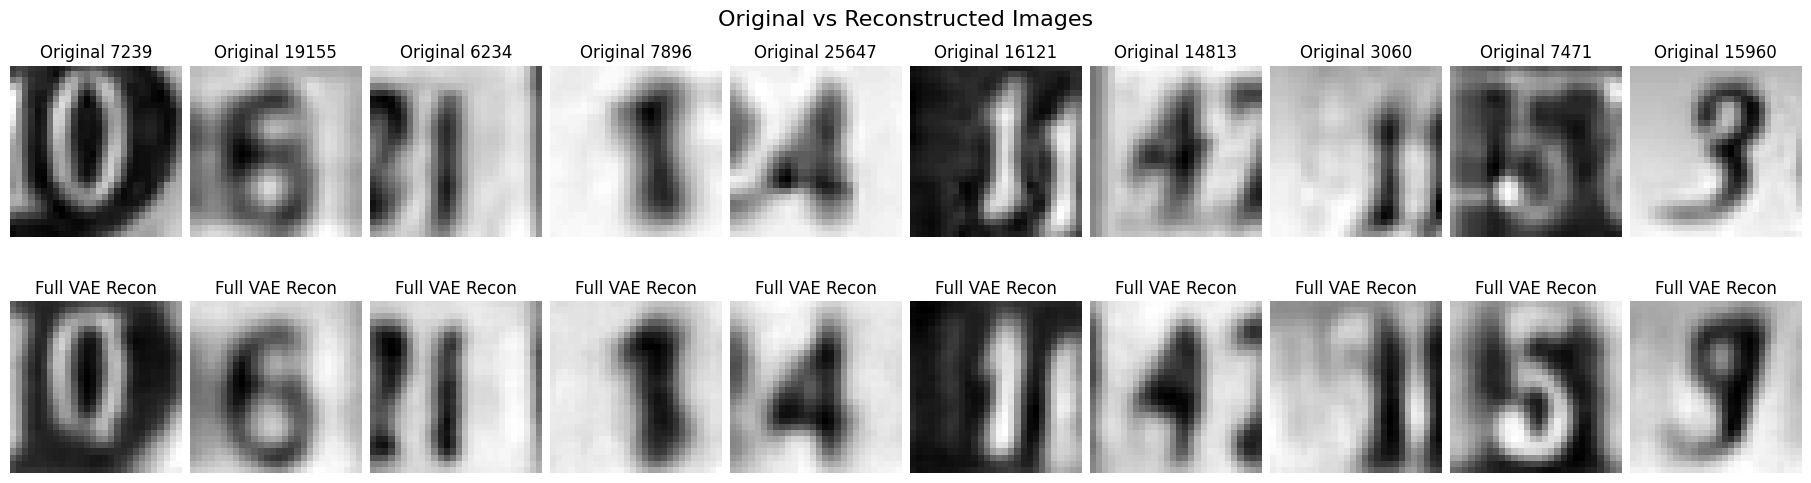

In [17]:
# Number of samples to visualize
num_samples = 10

# Randomly select indices for the samples
random_indices = np.random.choice(len(x_test_processed), num_samples, replace=False)

def visualize_comparisons(original_data, reconstructed_data_full, indices, figsize=(18, 5)):
    """
    Visualizes a comparison of original and reconstructed images.

    :param original_data: The dataset containing the original images.
    :param reconstructed_data_full: The dataset containing the reconstructed images from the full VAE model.
    :param indices: Indices of the images to be visualized.
    :param figsize: Size of the figure for the plots.
    """
    num_samples = len(indices)
    fig, axes = plt.subplots(2, num_samples, figsize=figsize, constrained_layout=True)
    
    for i, img_index in enumerate(indices):
        # Original Image
        ax = axes[0, i]
        original_img = original_data[img_index].reshape(28, 28)
        ax.imshow(original_img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Original {img_index}")

        # Reconstructed Image from full VAE model
        ax = axes[1, i]
        reconstructed_img_full = reconstructed_data_full.predict(original_data[img_index].reshape(1, 28, 28, 1))
        ax.imshow(reconstructed_img_full.reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Full VAE Recon")

    plt.suptitle("Original vs Reconstructed Images", fontsize=16)
    plt.show()

# Call the visualization function
visualize_comparisons(x_test_processed, pretrained_vae, random_indices)

In [18]:
# Random Sample
sample_size = 10  
indices = np.random.choice(range(len(x_test_processed)), size=sample_size, replace=False)
original_images = x_test_processed[indices]

# Generate reconstructed images using the full autoencoder
reconstructed_img_autoencoder = pretrained_vae.predict(original_images)



1/1 [==============================] - 0s 19ms/step


In [19]:
from keras.metrics import MeanSquaredError
from keras.losses import mse

# Function to calculate MSE
def calculate_mse(original, reconstructed):
    mse = MeanSquaredError()
    mse.update_state(original, reconstructed)
    return mse.result().numpy()

mse_autoencoder = calculate_mse(original_images, reconstructed_img_autoencoder)
#mse_encoder_decoder = calculate_mse(original_images, reconstructed_img_decoder)

print("MSE with Autoencoder:", mse_autoencoder)
#print("MSE with Encoder and Decoder:", mse_encoder_decoder)

MSE with Autoencoder: 0.0030125414


In [20]:
from skimage.metrics import structural_similarity as ssim


# Function to calculate SSIM
def calculate_ssim(original, reconstructed):
    # If images have a channel dimension, remove it
    if original.ndim == 3 and original.shape[-1] == 1:
        original = original.squeeze(-1)
    if reconstructed.ndim == 3 and reconstructed.shape[-1] == 1:
        reconstructed = reconstructed.squeeze(-1)

    return ssim(original, reconstructed, multichannel=False, win_size=11, data_range=1.0)  

# Calculate SSIM for autoencoder and decoder reconstructed images
ssim_autoencoder = np.mean([calculate_ssim(o, r) for o, r in zip(original_images, reconstructed_img_autoencoder)])
#ssim_decoder = np.mean([calculate_ssim(o, r) for o, r in zip(original_images, reconstructed_img_decoder)])

print("SSIM with Autoencoder:", ssim_autoencoder)
#print("SSIM with Decoder:", ssim_decoder)

SSIM with Autoencoder: 0.8976721998810033


In [21]:
from skimage.metrics import peak_signal_noise_ratio as psnr


# Function to calculate PSNR
def calculate_psnr(original, reconstructed):
    return psnr(original, reconstructed, data_range=original.max() - original.min())

# Calculate PSNR for autoencoder and encoder-decoder reconstructed images
psnr_autoencoder = np.mean([calculate_psnr(o, r) for o, r in zip(original_images, reconstructed_img_autoencoder)])
#psnr_decoder = np.mean([calculate_psnr(o, r) for o, r in zip(original_images, reconstructed_img_decoder)])

print("PSNR with Autoencoder:", psnr_autoencoder)
#print("PSNR with Decoder:", psnr_decoder)

PSNR with Autoencoder: 20.574145820818764
